In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import math
import numpy as np
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')


# remove outliers:
print(len(df))
pU, pL = np.percentile(df['?TourGeneration'], [99.85 ,0.15])
df = df.loc[df['?TourGeneration'] <= (pU)]
df = df.loc[df['?TourGeneration'] >= (pL)]
print(len(df))
pU, pL = np.percentile(df['TourContractGeneration'], [99.85 ,0.15])
df = df.loc[df['TourContractGeneration'] <= (pU)]
df = df.loc[df['TourContractGeneration'] >= (pL)]
print(len(df))

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}
dic1 = {'Yes':1,'No':0}
dic2 = {'In State':1,'Out of State':0}
dic3 = {'Owner':1,'1st Gen':0}
dic4 = {'Couple':1,'Single':0}
dic5 = {'Weekday':0, 'Weekend':1}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
df['Homeowner']=df['Homeowner'].replace(dic1)
df['InState']=df['InState'].replace(dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)
df['relationStatus']=df['relationStatus'].replace(dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)


df = df[df['ResultOfTour']==1]

print(df.info())




25777
25746
25710
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4848 entries, 196734 to 385719
Data columns (total 17 columns):
?TourGeneration               4848 non-null int64
Age                           4848 non-null int64
AgentLine                     4848 non-null object
BookingWindow                 4848 non-null object
FirstGenVsOwner               4848 non-null int64
HHIncomeRanges                4848 non-null object
Homeowner                     4848 non-null int64
InState                       4848 non-null int64
Month of TourDate             4848 non-null object
Programs (Budget)             4848 non-null object
relationStatus                4848 non-null int64
ResultOfTour                  4848 non-null int64
TourContractGeneration        4848 non-null int64
TourSeason                    4848 non-null object
WeekdayOrWeekend              4848 non-null int64
Year of TourDate              4848 non-null int64
NetVolumePlusNonGoodVolume    4848 non-null float64
dtypes: fl

In [4]:
# remove outliers from predicting model:
df['NetVolumePlusNonGoodVolume'] = (df['NetVolumePlusNonGoodVolume']+1).apply(np.sqrt)
print(len(df))
pU, pL = np.percentile(df['NetVolumePlusNonGoodVolume'], [99.85 ,0.15])
df = df.loc[df['NetVolumePlusNonGoodVolume'] <= (pU)]
df = df.loc[df['NetVolumePlusNonGoodVolume'] >= (pL)]
df['NetVolumePlusNonGoodVolume'] = np.power(df['NetVolumePlusNonGoodVolume'],2)-1
print(len(df))

4848
4832


In [5]:
dfX = df.drop(['ResultOfTour', 'NetVolumePlusNonGoodVolume'], axis = 1)

dfX['Year of TourDate'] = dfX['Year of TourDate'].astype(str) 

dfX = pd.get_dummies(dfX, prefix=[ 'AgentLine','BookingWindow',
       'HHIncomeRanges', 'Month of TourDate', 'Programs (Budget)','TourSeason', 'Year of TourDate'])

scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])

scaler2 = StandardScaler()
scaler2.fit(dfX[['TourContractGeneration']])
dfX['TourContractGeneration'] = scaler2.transform(dfX[['TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])


df['NetVolumePlusNonGoodVolume'] = np.log(df[['NetVolumePlusNonGoodVolume']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['NetVolumePlusNonGoodVolume'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train
 



print(dfX1.info())
print(np.mean(df['NetVolumePlusNonGoodVolume']))
print(np.mean(np.e**(df['NetVolumePlusNonGoodVolume'])))
print(np.mean((df['NetVolumePlusNonGoodVolume'])))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 351030 to 327529
Data columns (total 56 columns):
?TourGeneration                                3865 non-null float64
Age                                            3865 non-null float64
FirstGenVsOwner                                3865 non-null int64
Homeowner                                      3865 non-null int64
InState                                        3865 non-null int64
relationStatus                                 3865 non-null int64
TourContractGeneration                         3865 non-null float64
WeekdayOrWeekend                               3865 non-null int64
AgentLine_Breck                                3865 non-null uint8
AgentLine_Colorado                             3865 non-null uint8
AgentLine_Other Line                           3865 non-null uint8
BookingWindow_Inside 2 Days                    3865 non-null uint8
BookingWindow_Inside 90 days                   3865 non-null uint8
BookingWi

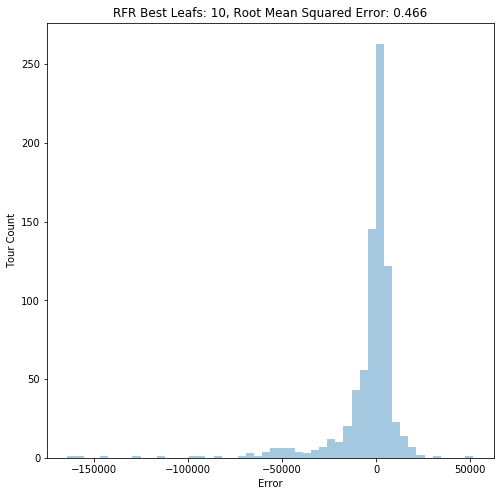

In [6]:
#change  figure size
mpl.rcParams['figure.figsize'] = (8,8)

bestLRFR =0
bestR2RFR=1
bestFIRFR = []
bestDiffRFR = []
i=0
#make cross validation of K values and kfold
Ls = [1,5,10,20,40]
np.random.shuffle(Ls)
kf = KFold(5, random_state= 0)


for train, test in kf.split(dfX1,dfY1):
    rfr = RandomForestRegressor(n_estimators=1000,min_samples_leaf=Ls[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = mean_squared_error(dfY1.iloc[test.tolist()], preds)**(1/2)
    if score < bestR2RFR:
        bestR2RFR = score
        bestLRFR = Ls[i]
        bestFIRFR = rfr.feature_importances_
        bestDiffRFR = np.e**(preds ) - np.e**(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
  
sns.distplot(bestDiffRFR, kde=False)
plt.ylabel('Tour Count')
plt.xlabel('Error')
plt.title('RFR Best Leafs: ' + str(bestLRFR)+ ', Root Mean Squared Error: '+ str(round(bestR2RFR,3)))
plt.show()



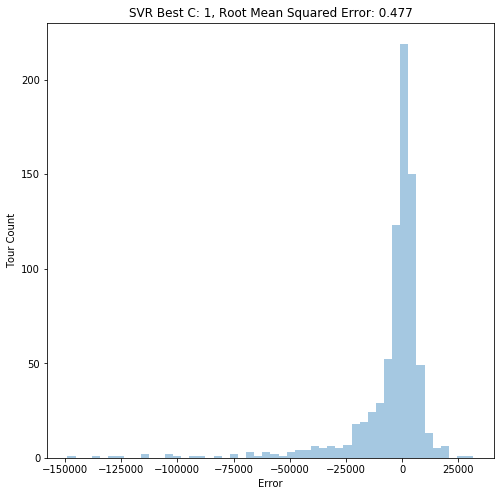

In [7]:
from sklearn.svm import SVR

#change  figure size
mpl.rcParams['figure.figsize'] = (8,8)

bestCSVR = 0
bestR2SVR = 1
bestDiffSVR = []

i=0
#make cross validation of K values and kfold
Cs = [0.01, 0.1, 1,10,100]
np.random.shuffle(Cs)
kf = KFold(5, random_state= 42)


for train, test in kf.split(dfX1,dfY1):
    rfr = SVR(C=Cs[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = mean_squared_error(dfY1.iloc[test.tolist()], preds)**(1/2)
    if score < bestR2SVR:
        bestR2SVR = score
        bestCSVR = Cs[i]
        bestDiffSVR = np.e**(preds ) - np.e**(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
sns.distplot(bestDiffSVR, kde=False)
plt.ylabel('Tour Count')
plt.xlabel('Error')
plt.title('SVR Best C: ' + str(bestCSVR)+ ', Root Mean Squared Error: '+ str(round(bestR2SVR,3)))
plt.show()



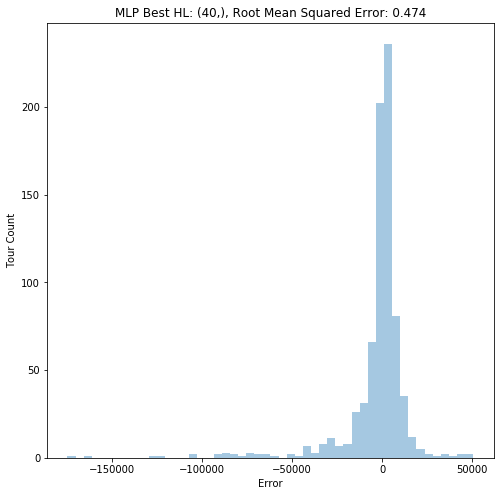

In [8]:
from sklearn.neural_network import MLPRegressor
import itertools 

bestHL = 0
bestR2HL = 1
bestDiffMLP = []
i = 0

colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,5,10,20,40),repeat=1)]

#change  figure size
mpl.rcParams['figure.figsize'] = (8,8)


np.random.shuffle(HLs)
kf = KFold(5, random_state= 42)


for train, test in kf.split(dfX1,dfY1):
    rfr = MLPRegressor(hidden_layer_sizes=HLs[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = mean_squared_error(dfY1.iloc[test.tolist()], preds)**(1/2)
    if score < bestR2HL:
        bestR2HL = score
        bestHL = HLs[i]
        bestDiffMLP = np.e**(preds ) - np.e**(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
sns.distplot(bestDiffMLP, kde=False)
plt.ylabel('Tour Count')
plt.xlabel('Error')
plt.title('MLP Best HL: ' + str(bestHL)+ ', Root Mean Squared Error: '+ str(round(bestR2HL,3)))
plt.show()

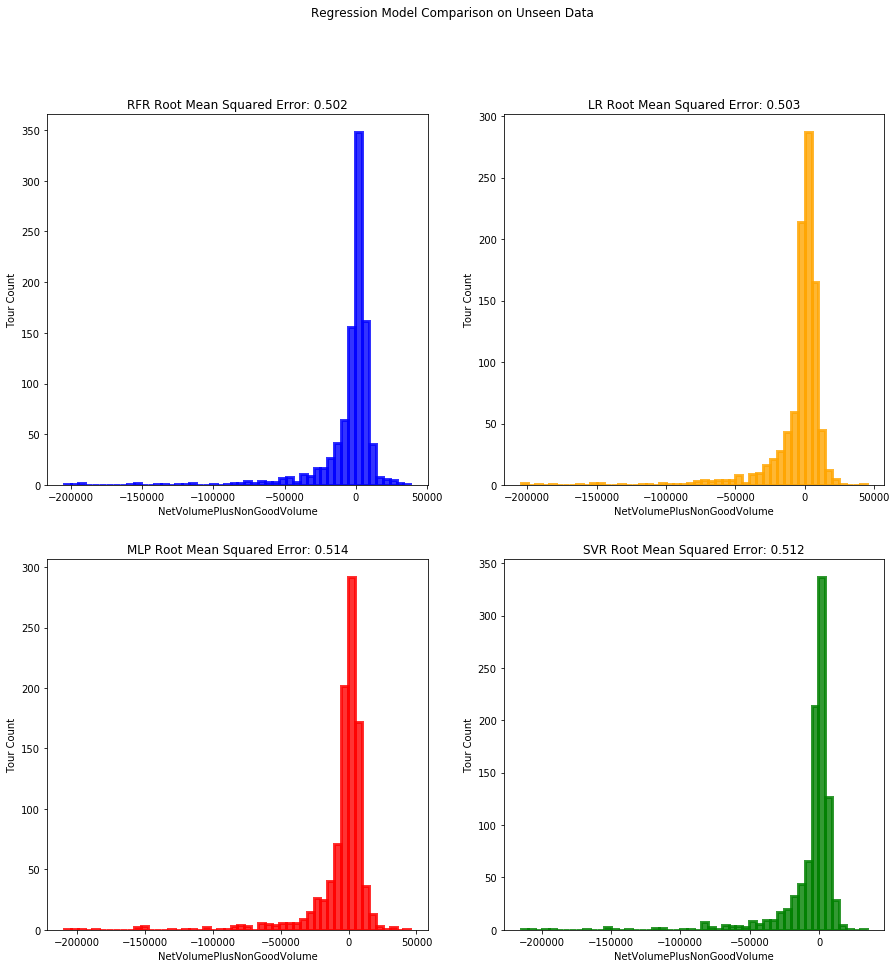

In [9]:
y_t = pd.DataFrame()
y_t = y_test.copy()

y_t = np.e**(y_t)

# removed linear regression because some error in code below
lr = LinearRegression(fit_intercept =False)
lr.fit(dfX1,dfY1)
predsLR = lr.predict(X_test)
lrScore = mean_squared_error(y_test, predsLR)**(1/2)
diffLR = np.e**(predsLR ) - (y_t )

#random forest best model 
rf = RandomForestRegressor(n_estimators=1000,min_samples_leaf =bestLRFR,random_state=42)
rf.fit(dfX1,dfY1)
predsRFR = rf.predict(X_test)
rfrScore = mean_squared_error(y_test, predsRFR)**(1/2)
diffRFR = np.e**(predsRFR ) - (y_t )


#support vector best model
svr = SVR(C=bestCSVR)
svr.fit(dfX1,dfY1)
predsSVR = svr.predict(X_test)
svrScore = mean_squared_error(y_test, predsSVR)**(1/2)
diffSVR = np.e**(predsSVR ) - (y_t )

# mlp regressor
mlp = MLPRegressor(hidden_layer_sizes=bestHL)
mlp.fit(dfX1,dfY1)
predsMLP = mlp.predict(X_test)
mlpScore = mean_squared_error(y_test, predsMLP)**(1/2)
diffMLP = np.e**(predsMLP ) - (y_t )

#change  figure size
mpl.rcParams['figure.figsize'] = (15,15)

plt.subplot(2,2,1)
plt.title('RFR Root Mean Squared Error: '+ str(round(rfrScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffRFR, kde=False, color = 'Blue', hist_kws=dict(alpha=0.8,edgecolor="Blue", linewidth=3) )
plt.subplot(2,2,2)
plt.title('LR Root Mean Squared Error: '+ str(round(lrScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffLR, kde=False, color = 'Orange',   hist_kws=dict(alpha=0.8,edgecolor="Orange", linewidth=3))
plt.subplot(2,2,3)
plt.title('MLP Root Mean Squared Error: '+ str(round(mlpScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffMLP, kde=False, color = 'Red',   hist_kws=dict(alpha=0.8,edgecolor="Red", linewidth=3))
plt.subplot(2,2,4)
plt.title('SVR Root Mean Squared Error: '+ str(round(svrScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffSVR, kde=False, color = 'Green', hist_kws=dict(alpha=0.8,edgecolor="Green", linewidth=3))
plt.suptitle('Regression Model Comparison on Unseen Data')
plt.show()

In [10]:
print('Random Forest Regression Feature Importances: ')
print()
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(str(round(x,4)),'\t: ',str(y) )

Random Forest Regression Feature Importances: 

0.2054 	:  InState
0.1078 	:  Age
0.0953 	:  HHIncomeRanges_350k to 500k
0.0702 	:  HHIncomeRanges_Over 500k
0.0654 	:  TourContractGeneration
0.0653 	:  ?TourGeneration
0.0505 	:  HHIncomeRanges_200k to 349k
0.0379 	:  Year of TourDate_2016
0.028 	:  HHIncomeRanges_90k to 149k
0.0249 	:  HHIncomeRanges_150k to 199k
0.0216 	:  Programs (Budget)_(14) Summit County OPC
0.0212 	:  Month of TourDate_March
0.0196 	:  HHIncomeRanges_70k to 89k
0.0142 	:  TourSeason_Winter
0.0118 	:  WeekdayOrWeekend
0.0115 	:  Year of TourDate_2018
0.0109 	:  Month of TourDate_February
0.0102 	:  Year of TourDate_2017
0.0102 	:  Programs (Budget)_(09) GL7 Inhouse
0.0094 	:  TourSeason_Spring
0.0091 	:  BookingWindow_Inside 2 Days
0.009 	:  Programs (Budget)_(21) GTL In House
0.0079 	:  AgentLine_Breck
0.0077 	:  FirstGenVsOwner
0.0068 	:  Month of TourDate_May
0.0066 	:  Programs (Budget)_(12) Outbound Telemarktng
0.0066 	:  AgentLine_Colorado
0.0057 	:  TourSe

In [11]:
print(np.mean(np.e**(rf.predict(X_test))))
print(np.min(np.e**(rf.predict(X_test))))
print(np.max(np.e**(rf.predict(X_test))))

19818.491659709354
11584.66833928518
87418.6882751111


In [12]:
print(np.mean(np.e**(y_test)))
print(np.min(np.e**(y_test)))
print(np.max(np.e**(y_test)))

25180.885729058944
7023.899999999994
254200.0


In [13]:
print(np.mean(np.e**(svr.predict(X_test))))
print(np.min(np.e**(svr.predict(X_test))))
print(np.max(np.e**(svr.predict(X_test))))

18224.76988435037
9806.785692422298
51888.831431436054
